# CellRank2 analysis of TE001
CellRank2 analysis of TE001 using CellRank2 ConnectivityKernel

###  Import packages and data
Setup path to data-containing folder and savings and parameters


In [1]:
# a.1) setup path to data-containing folder and savings and parameters
h5ad_path = "/Volumes/ac_lab_scratch/lz2841/ics-rebuttal/TE001-h5ad/"
figures_dir = "/Volumes/ac_lab_scratch/lz2841/ics-rebuttal/figures/"
figures_dir_Connectivity = "/Volumes/ac_lab_scratch/lz2841/ics-rebuttal/figures/CR2_ConnectivityKernel/" # where to save figures for connectivity kernel


n_macro_Connectivity= 7 # number of macrostates

Import packages and set markers of interest

In [2]:
# a.2) packages
import sys
import cellrank as cr
import scanpy as sc
import numpy as np
import pandas as pd
import os
from matplotlib import rc_context
import matplotlib.pyplot as plt
sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

import warnings
warnings.simplefilter("ignore", category=UserWarning)

cytotrace_markers = ['Smarca5','Rbbp7','Tcerg1','Hnrnpd','Hmg20b','Nelfe','Ube2i','Etv5','Ubn1','Mbd3','Dek','Maz',
                     'Itgb3bp','Ilf2','Pa2g4'] # Id3','Hnf4g','Atoh1','Spdef','Neurod1' markers upregulated in cytotrace (Fig 1e) 


In [3]:
# a.3) load counts data (exported from Seurat@RNA assay)
counts_h5ad = h5ad_path + "TE001-counts.h5ad"
adata = sc.read_h5ad(counts_h5ad) # load in object


# a.4) load metadata for TE001 
metadata_csv = h5ad_path + "TE001-metadata-umap-and-clusters-for-paper.csv"
metadata = pd.read_csv(metadata_csv)

# a.5) process metadata in adata
specified_columns = ["cell_id", "nCount_RNA", "nFeature_RNA", "mt_percent", "cytotrace_score.ges",
                     "cytotrace_gcs.ges", "S.Score", "G2M.Score", "Phase", "seurat_clusters", "singleR_labels", "stemness_index.ges"]

adata.obs = adata.obs[specified_columns]
cells_to_analyze = metadata['cell_id'] # cells to analyze
adata = adata[adata.obs_names.isin(cells_to_analyze)] # subset cells to analyze in adata

adata.obs = pd.merge(adata.obs, metadata, on='cell_id', how='left') # merge metadata and include into counts object
 
adata.obs['seurat_clusters'] = adata.obs['seurat_clusters'].astype('category') # clusters as categorical variable

# a.6) set UMAP coordinates to those obtained at protein activty
umap_coordinates = np.array(adata.obs.loc[:, ['UMAP_1_scanpy','UMAP_2_scanpy']]) 
adata.obsm['X_umap'] = umap_coordinates


# a.7) Include metadata of terminal states for CellRank analysis
adata.obs['terminal_states'] = adata.obs['iter_cluster_id_with_paneth']
adata.obs['terminal_states'].iloc[adata.obs['terminal_states'].isin(["stem-1","stem-2"])] = np.nan

print("adata contains the counts for the TE001 dataset")
#counts = adata.raw.to_adata() # the adata already contains the counts matrix

adata contains the counts for the TE001 dataset


UMAP showing Lgr4 and Lgr5 expression


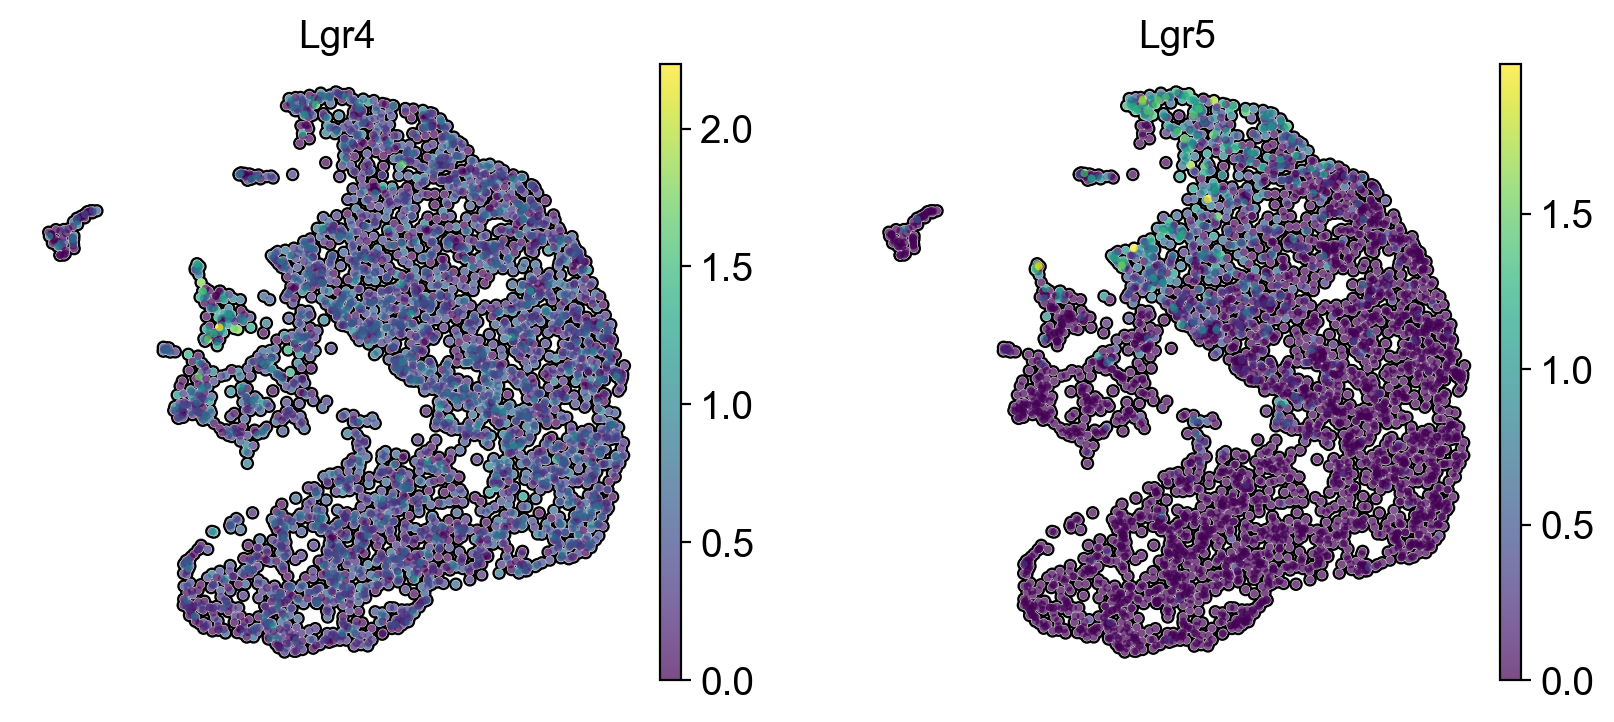

In [4]:
# a.8) display specific marker genes
log_expression = adata.copy()
sc.pp.normalize_total(log_expression, target_sum=1e4)
sc.pp.log1p(log_expression)

print("UMAP showing Lgr4 and Lgr5 expression")
sc.pl.umap(log_expression,color=["Lgr4","Lgr5"], use_raw=False, cmap='viridis',add_outline=True)

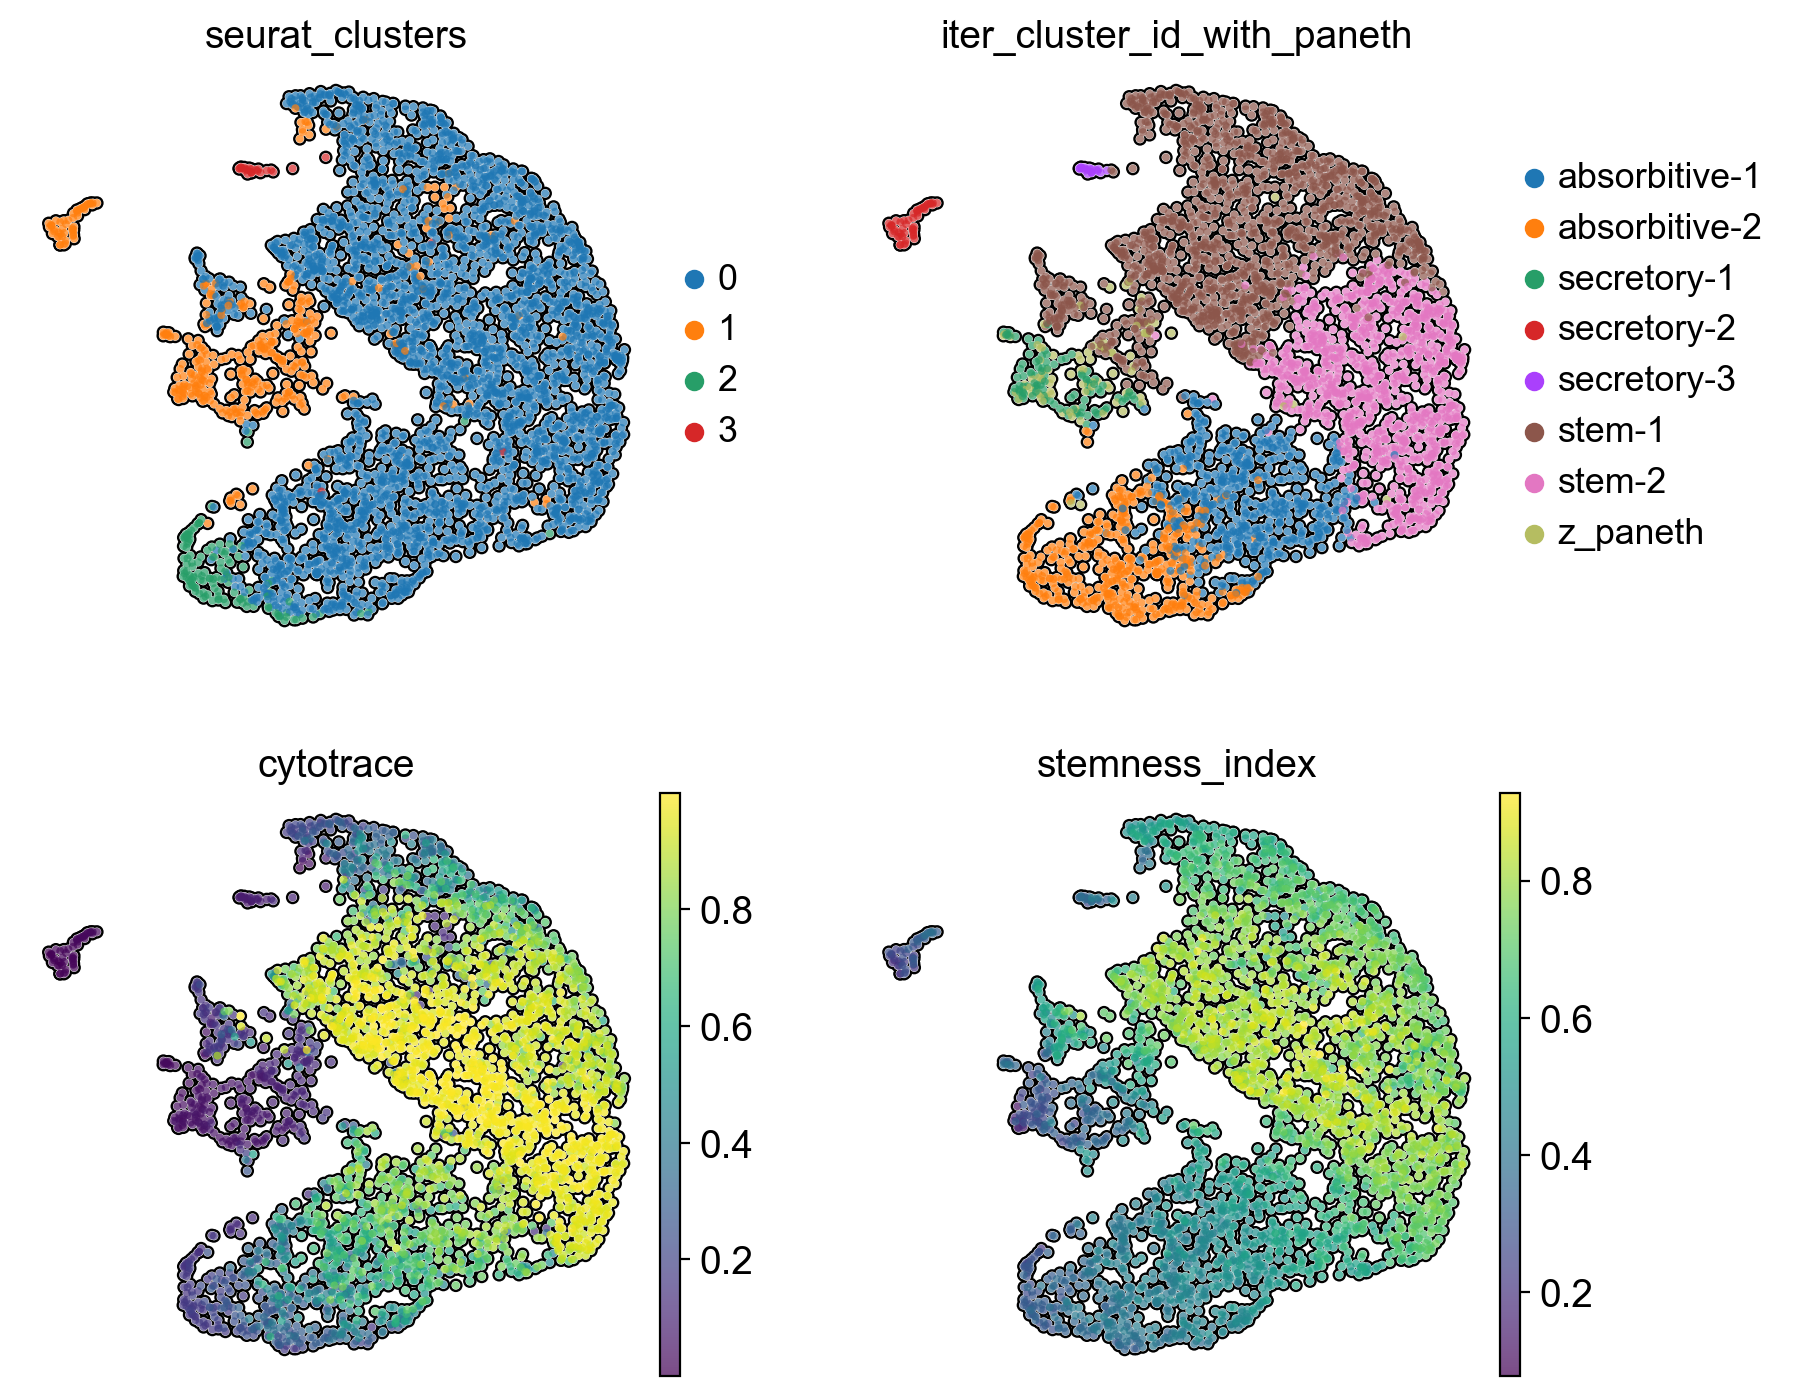

In [5]:
sc.pl.umap(adata, color=["seurat_clusters","iter_cluster_id_with_paneth","cytotrace","stemness_index"], ncols=2, add_outline=True)

Preprocess data for CellRank2 analysis

In [6]:
### b) Preprocess the data 
print("Preprocessing counts matrix for CellRank 2 analysis")
sc.tl.pca(adata, random_state=0)
sc.pp.neighbors(adata, random_state=0)

Preprocessing counts matrix for CellRank 2 analysis


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### CellRank2 analysis with Connectivity Kernel
Import CellRank2 Connectivity kernel and compute transition matrix for CellRank2 analysis

In [7]:
##########################################################################################################
##########################################################################################################
### CellRank2 analysis with Connectivity Kernel
##########################################################################################################
##########################################################################################################



### h) Connectivity kernel
# h.1) Setup kernel 
print("Working with Connectivity kernel")
from cellrank.kernels import ConnectivityKernel 


# h.2) compute transition matrix
ck = ConnectivityKernel(adata).compute_transition_matrix()

Working with Connectivity kernel
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


Initialize directory to save figures.

In [8]:
if os.path.exists(figures_dir_Connectivity):
    print("'figures_dir_Connectivity' directory already exists")
else:
    os.mkdir(figures_dir_Connectivity)


'figures_dir_Connectivity' directory already exists


Simulate Random Walk on the Markov Chain implied by the Transition Probability matrix computed with CellRank 2 

Simulating `100` random walks of maximum length `914`


  0%|          | 0/100 [00:00<?, ?sim/s]

    Finish (0:00:05)
Plotting random walks
Simulating `100` random walks of maximum length `914`


  0%|          | 0/100 [00:00<?, ?sim/s]

    Finish (0:00:05)
Plotting random walks
Simulating `100` random walks of maximum length `914`


  0%|          | 0/100 [00:00<?, ?sim/s]

    Finish (0:00:05)
Plotting random walks


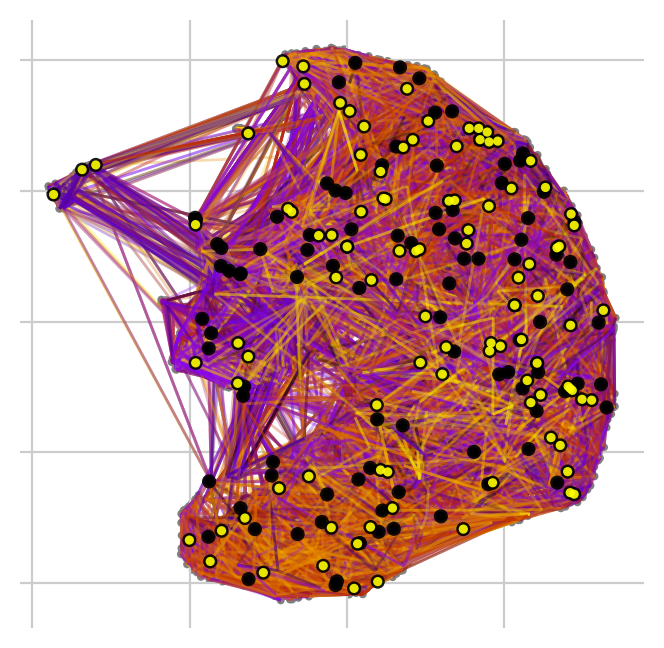

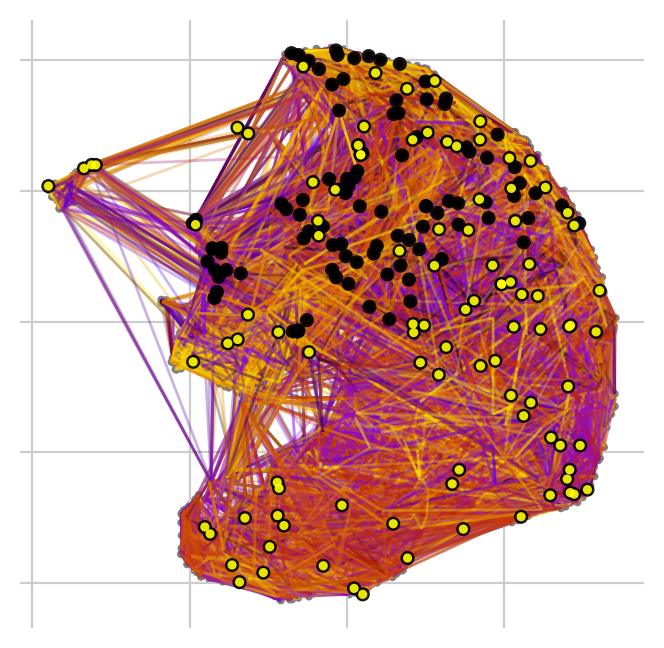

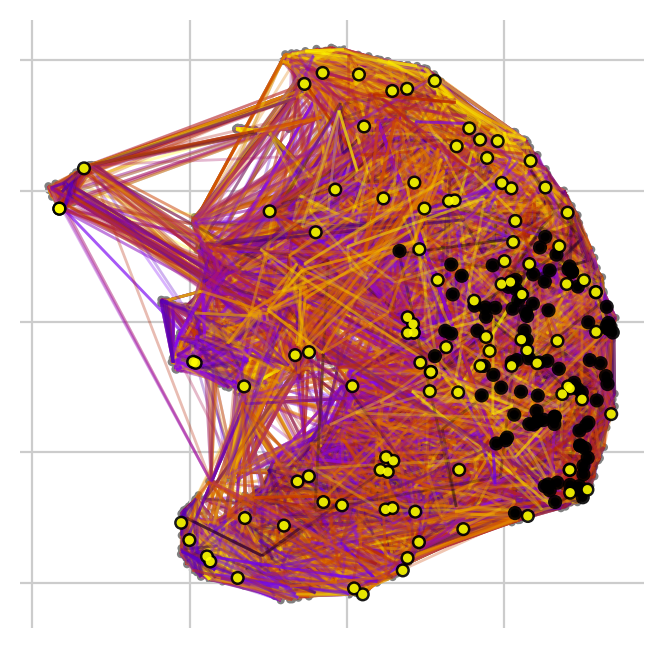

In [9]:
# h.3) Simulate a random walk on the Markov chain implied by the transition matrix 
# sampling cells randomly among all clusters
ck_rw_figure = figures_dir_Connectivity + "Connectivity_random_walk.pdf"
ck.plot_random_walks(
    seed=0,
    n_sims=100,
    start_ixs=None,
    legend_loc="right",
    dpi=100,
    save=ck_rw_figure
)

# h.4) visualize the transition matrix
# sampling cells randomly from stem-1 population
ck_rw_figure = figures_dir_Connectivity + "Connectivity_random_walk_stem-1.pdf"
ck.plot_random_walks(
    seed=0,
    n_sims=100,
    start_ixs={'iter_cluster_id_with_paneth': ["stem-1"]},
    legend_loc="right",
    dpi=100,
    save=ck_rw_figure
)

# sampling cells randomly from stem-2 population
ck_rw_figure = figures_dir_Connectivity + "Connectivity_random_walk_stem-2.pdf"
ck.plot_random_walks(
    seed=0,
    n_sims=100,
    start_ixs={'iter_cluster_id_with_paneth': ["stem-2"]},
    legend_loc="right",
    dpi=100,
    save=ck_rw_figure
)



Visualize the projected transition probability matrix inferred with CellRank 2 and the ConnectivityKernel as streamlines on a UMAP, with cells colored by clusters at gene expression (Panel 1) and protein activity (Panel 2).

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Volumes/ac_lab_scratch/lz2841/ics-rebuttal/figures/CR2_ConnectivityKernel/Connectivity_differentiation_ges_clusters.png


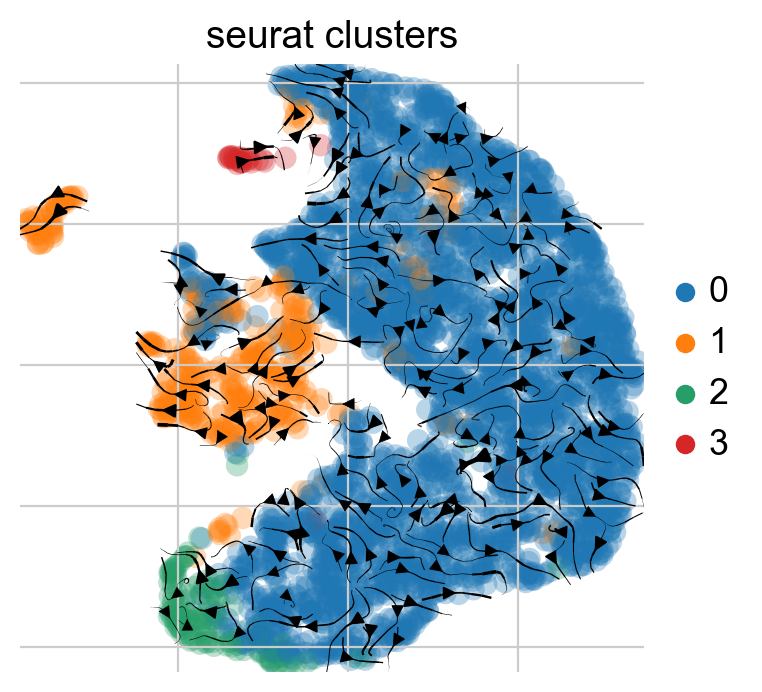

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Volumes/ac_lab_scratch/lz2841/ics-rebuttal/figures/CR2_ConnectivityKernel/Connectivity_differentiation_pa_clusters.png


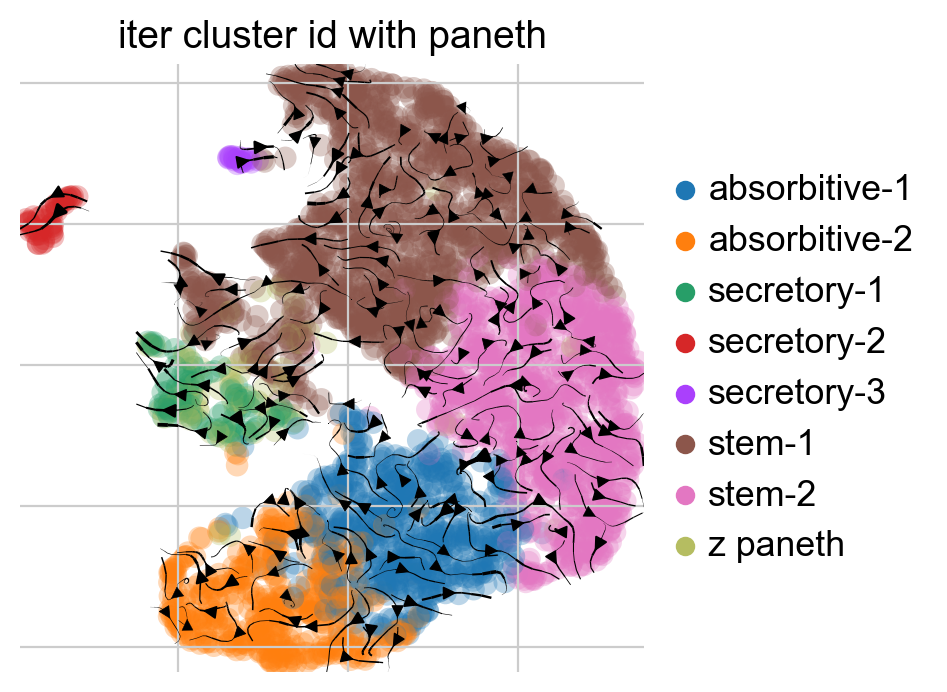

In [14]:
# h.4) visualize the transition matrix
differentiation_figure = figures_dir_Connectivity + "Connectivity_differentiation_ges_clusters.png"
ck.plot_projection(basis="umap", color="seurat_clusters", 
                    legend_loc="right", save=differentiation_figure, show=True)


differentiation_figure = figures_dir_Connectivity + "Connectivity_differentiation_pa_clusters.png"
ck.plot_projection(basis="umap", color="iter_cluster_id_with_paneth", 
                    legend_loc="right", save=differentiation_figure, show=True)



# h.5) Check terminal states from annotations
#sc.pl.embedding(adata, basis="umap", color="terminal_states", add_outline=True)



Analysing Connectivity kernel with GPCCA
Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:03)
Computing `7` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
saving figure to file /Volumes/ac_lab_scratch/lz2841/ics-rebuttal/figures/CR2_ConnectivityKernel/GPCCA_macrostates.pdf
Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
saving figure to file /Volumes/ac_lab_scratch/lz2841/ics-rebuttal/figures/CR2_ConnectivityKernel/GPCCA_terminal_states.pdf


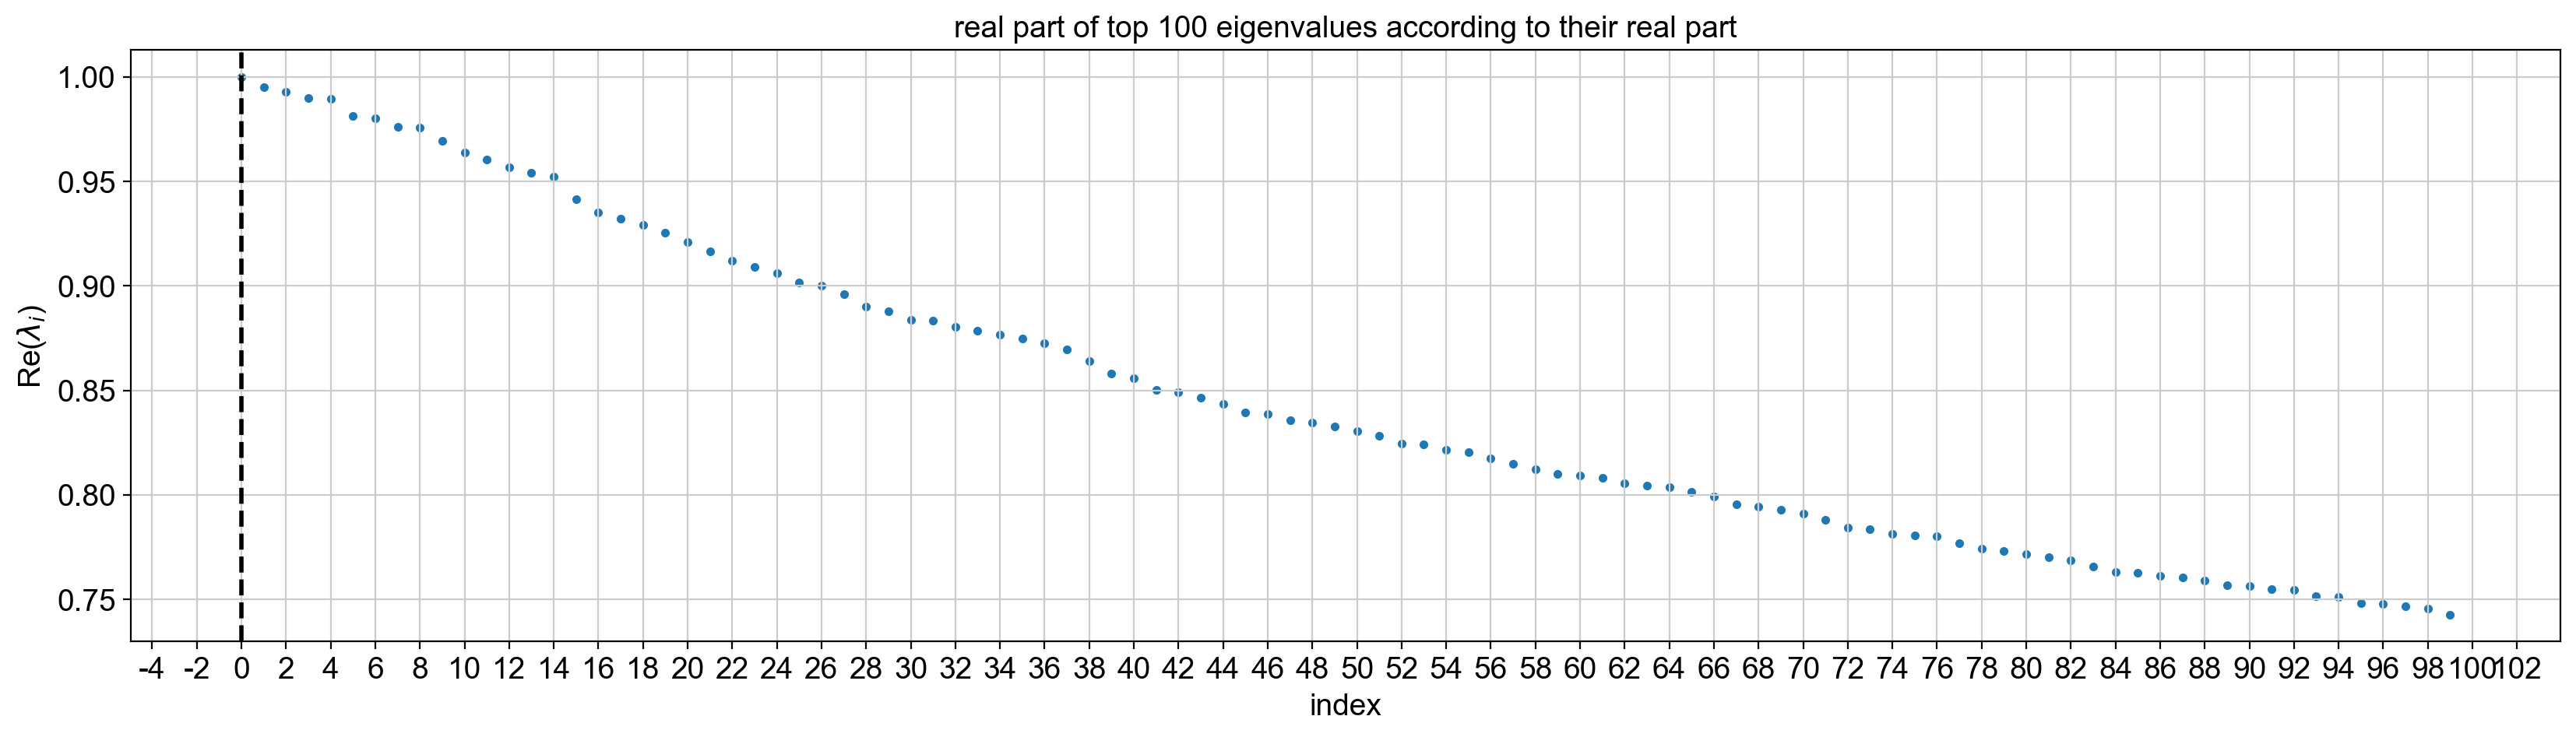

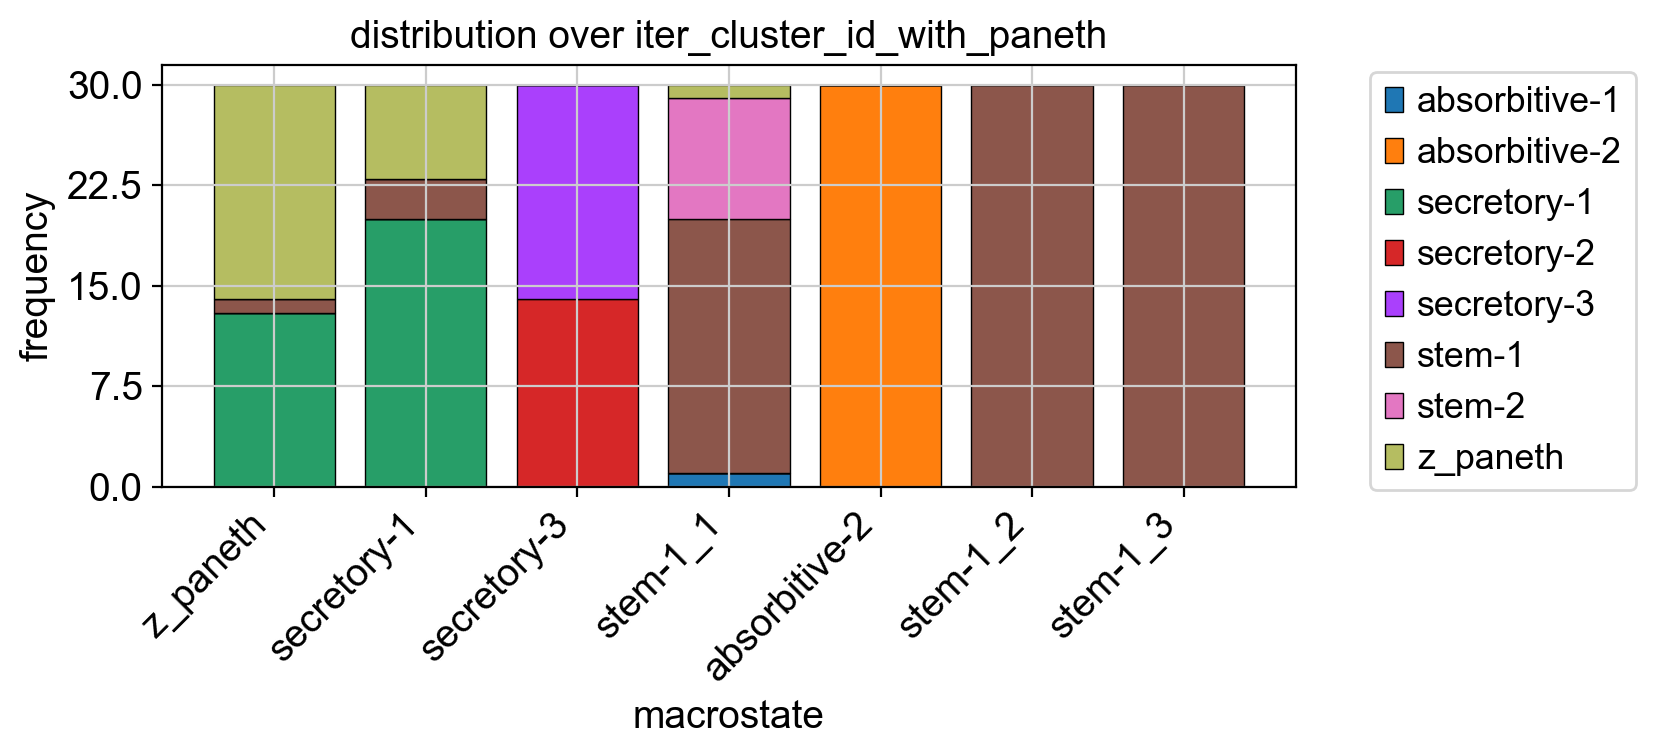

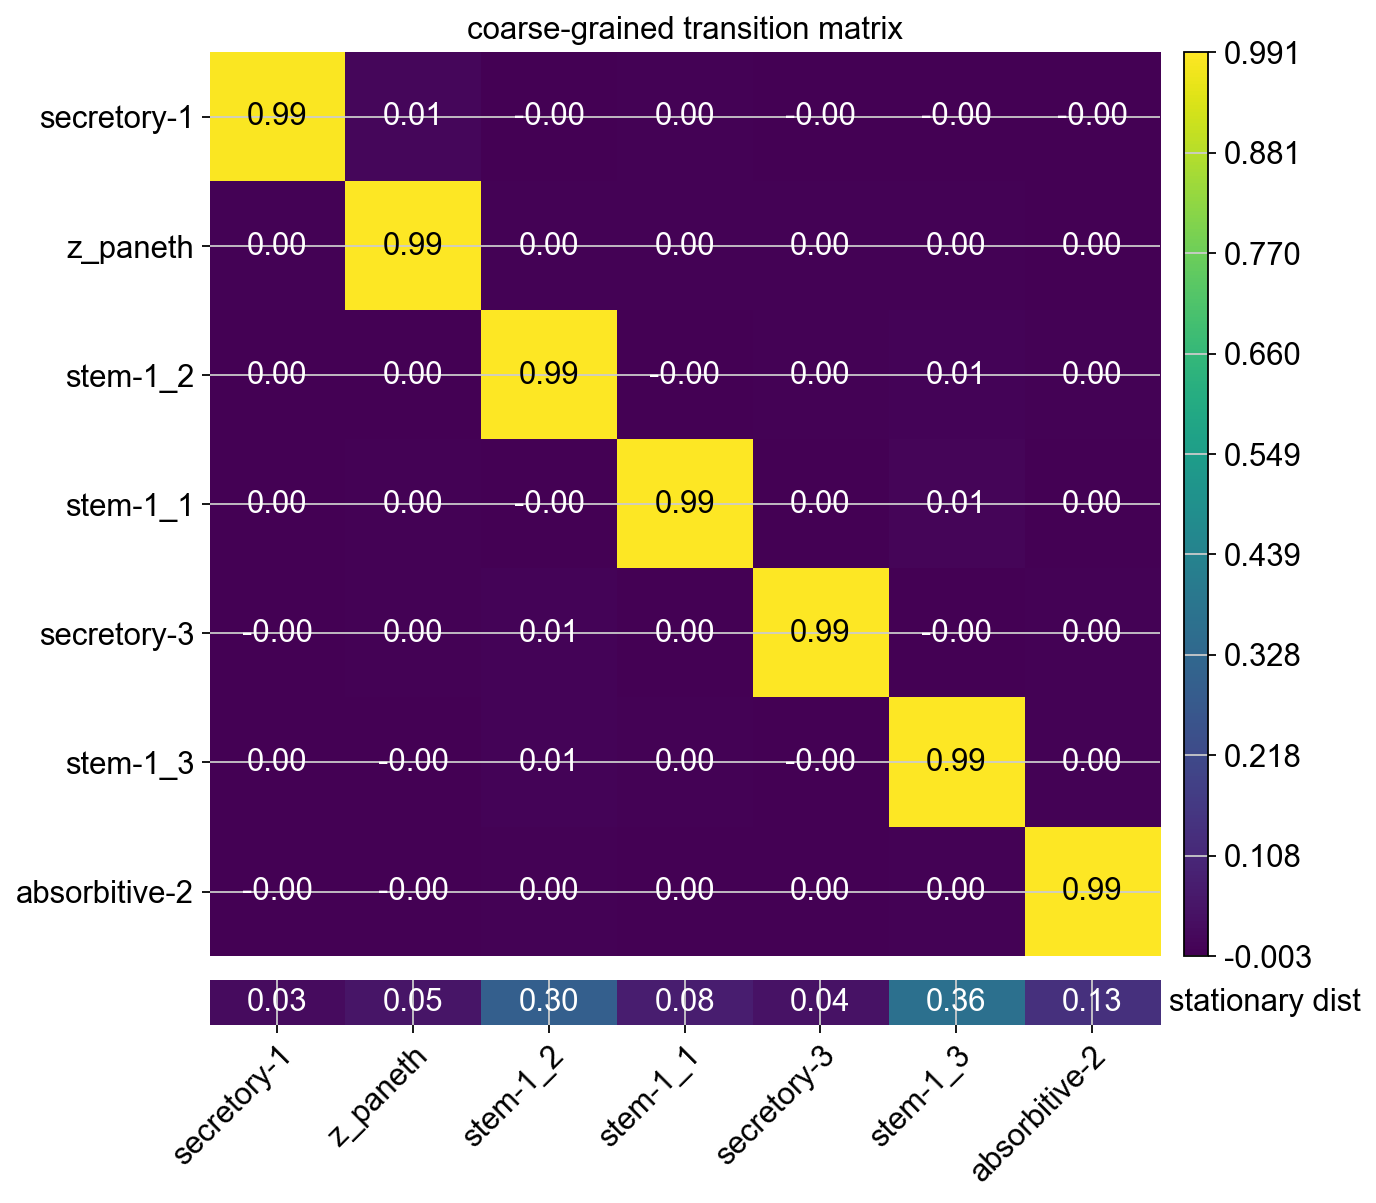

In [11]:
#############################################

### i) Analyze Connectivity kernel with estimators 
# # i.1) Setup estimator 
from cellrank.estimators import GPCCA
from cellrank.estimators import CFLARE
print("Analysing Connectivity kernel with GPCCA")

# i.1) compute estimator
g_ck = GPCCA(ck)
g_ck.compute_schur(n_components=100) # compute Schur decomposition
eig_figure = figures_dir_Connectivity + "GPCCA_eig.pdf"
g_ck.plot_spectrum(real_only=True, n=None, show_all_xticks=False, save=eig_figure, figsize=(20,5))

g_ck.compute_macrostates(n_states=n_macro_Connectivity, cluster_key="iter_cluster_id_with_paneth")
macrostates_figure = figures_dir_Connectivity + "GPCCA_macrostates.pdf"
g_ck.plot_macrostates(which="all", legend_loc="right", s=100, save=macrostates_figure, show=False)

macrostates_figure_composition = figures_dir_Connectivity + "GPCCA_macrostates_composition.pdf"
g_ck.plot_macrostate_composition(key="iter_cluster_id_with_paneth", figsize=(8.5,4), show=False, save=macrostates_figure_composition) # composition of each macrostate


coarse_T_figure = figures_dir_Connectivity + "GPCCA_coarse_T.pdf"
g_ck.plot_coarse_T(annotate=True, save=coarse_T_figure) # plot transition matrix


# i.2) compute terminal states
g_ck.predict_terminal_states()
terminal_states_figure = figures_dir_Connectivity + "GPCCA_terminal_states.pdf"
g_ck.plot_macrostates(which="terminal", legend_loc="right", s=100, save=terminal_states_figure, show=False)


# i.3) predict initial states
#g_ck.predict_initial_states(allow_overlap=True)
#g_ck.plot_macrostates(which="initial", s=100)



Computing fate probabilities


  0%|          | 0/7 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)
saving figure to file /Volumes/ac_lab_scratch/lz2841/ics-rebuttal/figures/CR2_ConnectivityKernel/Fate_probability.pdf
Solving TSP for `7` states


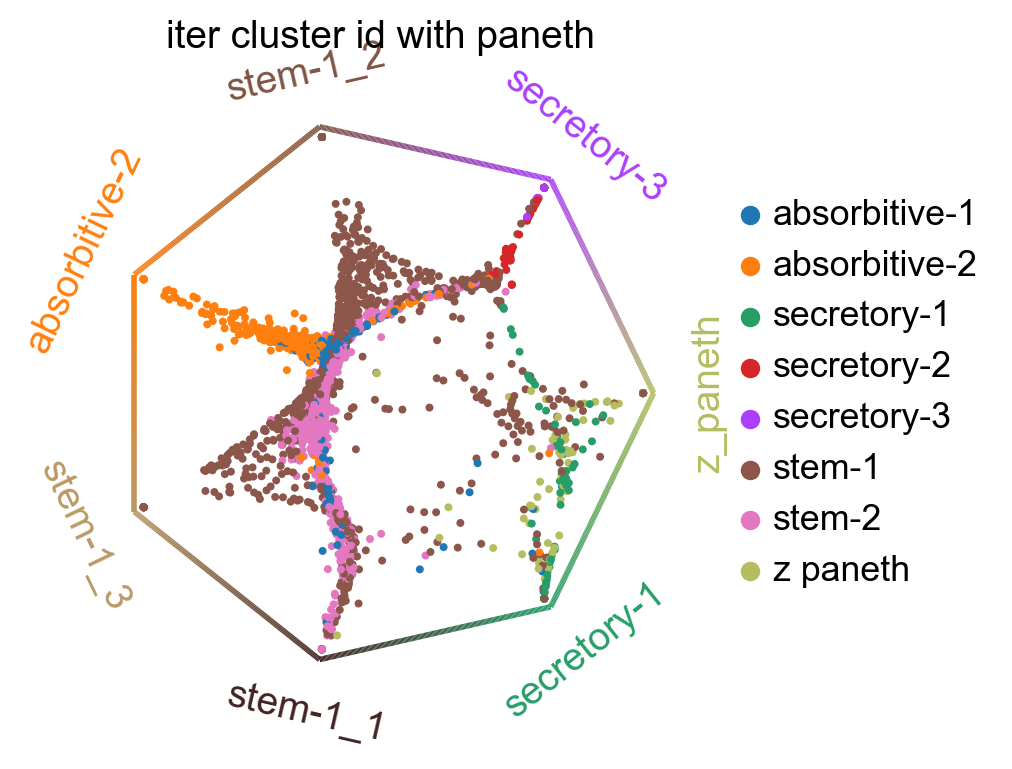

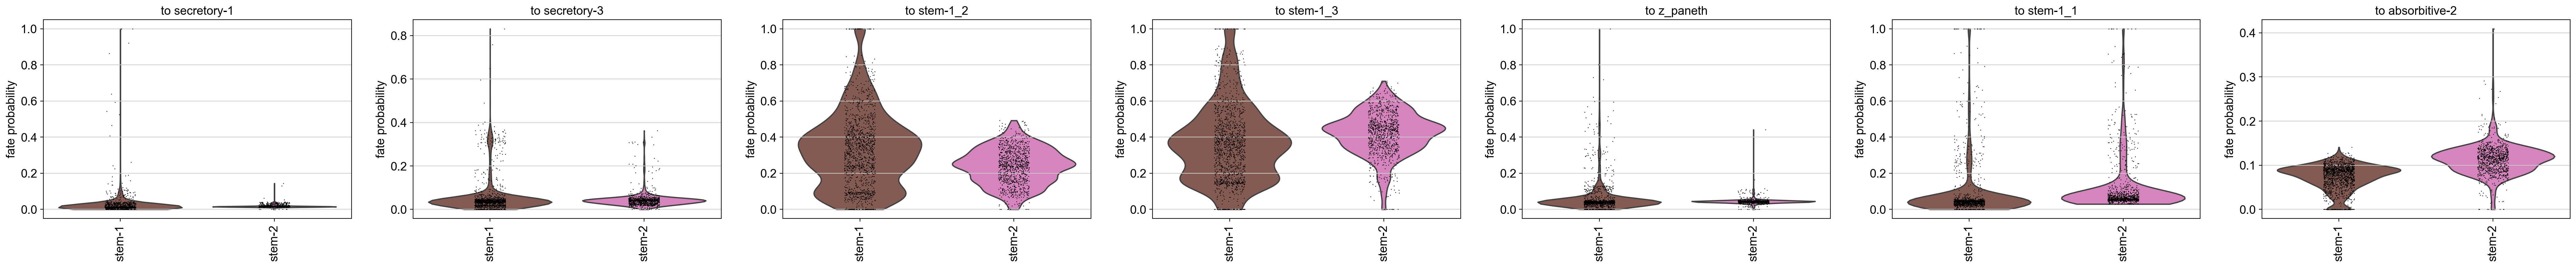

In [12]:
#########################################################
# j) Estimating Fate Probabilities for Connectivity kernel

# j.1) compute fate probabilities towards identified terminal states
g_ck.compute_fate_probabilities()

# j.2) visualize fate probabilities on UMAP
fate_probability_figure = figures_dir_Connectivity + "Fate_probability.pdf"
g_ck.plot_fate_probabilities(same_plot=False, vmax=1,show=False, save=fate_probability_figure)

# j.3) visualize fate probabilities on a circular projection
fate_circular_figure = figures_dir_Connectivity + "Fate_circular.pdf"
cr.pl.circular_projection(adata, keys="iter_cluster_id_with_paneth", legend_loc="right", save=fate_circular_figure)

# j.4) aggregate fate probabilities and visualize how they are committed towards selected cell types   
progenitor_states = ["stem-1", "stem-2"] # select stem-1 and stem-2 as the progenitor states to aggregate their probabilities
fate_committed_vln_figure = figures_dir_Connectivity + "Fate_committed_vln.pdf"
ck_terminal_states = g_ck.terminal_states.unique().dropna().to_list()
cr.pl.aggregate_fate_probabilities(
    adata,
    mode="violin",
    lineages=ck_terminal_states, 
    cluster_key="iter_cluster_id_with_paneth",
    clusters=progenitor_states,
    save=fate_committed_vln_figure
)

In [ ]:
cr.logging.print_versions()
